In [22]:
import yfinance as yf # yfiance can also directly be used to get data
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import openpyxl


from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix

## Adjusted Stock Prices

[*********************100%***********************]  6 of 6 completed


Text(0.5, 1.0, 'Normalized Price Performance of Selected Assets')

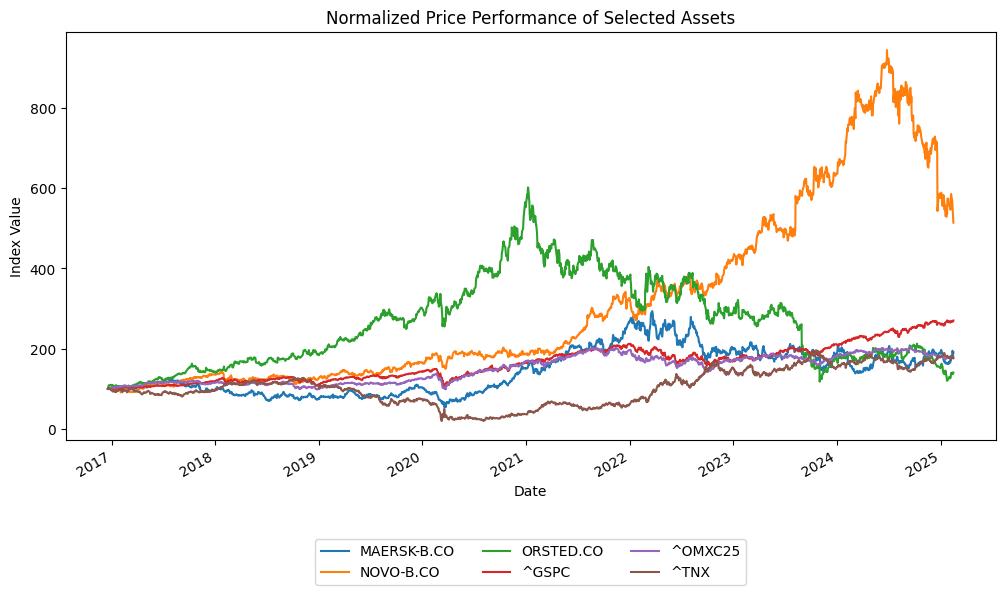

In [23]:
# Define the tickers
tickers = [
    "^TNX",        # US Treasury Bond Returns (10-Year Yield)
    "^GSPC",       # S&P 500 Index
    "MAERSK-B.CO",        # Maersk
    "ORSTED.CO",   # Ørsted
    "NOVO-B.CO",   # Novo Nordisk
    #BTC-USD",  # iShares Bitcoin ETF (if available, otherwise use BITO)
    "^OMXC25"      # OMX Copenhagen 25 Index
]

# Download historical data
data = yf.download(tickers, start=datetime.date(2013,1,1), auto_adjust=False)

# Get close prices and normalize
close_prices = data['Adj Close'].dropna()   #Removing dates with missing value
normalized_prices = close_prices / close_prices.iloc[0, :] * 100

# Plot the normalized prices
ax = normalized_prices.plot(figsize=(12, 6))
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), ncol=3)  # Adjust legend position
ax.set_ylabel('Index Value') #Normalized to 100
ax.set_title('Normalized Price Performance of Selected Assets')

In [24]:
normalized_prices_adj_log_ret = np.log(normalized_prices / normalized_prices.shift(1)).dropna()

In [25]:
normalized_prices_adj_log_ret.tail()

Ticker,MAERSK-B.CO,NOVO-B.CO,ORSTED.CO,^GSPC,^OMXC25,^TNX
Date,,,,,,
2025-02-10,0.029684,-0.021700,0.001674,0.006690,-0.002909,0.001336
2025-02-11,0.060903,-0.025010,0.004007,0.000340,0.005274,0.009745
2025-02-12,-0.023752,-0.024455,-0.026677,-0.002728,-0.006692,0.021802
2025-02-13,-0.023906,-0.034214,0.017639,0.010372,0.003651,-0.024450
2025-02-14,0.026802,-0.015132,0.011368,-0.000072,-0.000704,-0.011782



We want to specify an exponential filter to estimate the covariance matrix. To that end, we define ($\mathbf{x}_t$ is the return vector at time $t$)

$$
\boldsymbol{\mu}^{\lambda}_{T+1} = \gamma \sum_{t=1}^T e^{-\lambda (T-t)} \mathbf{x}_t
$$

and 

$$
\boldsymbol{\Sigma}^{\lambda}_{T+1} = \gamma \sum_{t=1}^T e^{-\lambda (T-t)} \mathbf{x}_t \mathbf{x}_t^\top  - \boldsymbol{\mu}^{\lambda}_{T+1} (\boldsymbol{\mu}^{\lambda}_{T+1})^\top
$$

where $\gamma = 1 /  \sum_{t=1}^T e^{-\lambda (T-t)}$ to make the weights sum to one. $\lambda$ controls the decay of the exponential filter. A $\lambda=0.0055$ will represent a half-life of approximately six months with daily data. 

Implement the exponential filter and apply it with $\lambda=0.0055$ 


In [26]:
data = normalized_prices_adj_log_ret.values

def covariance_exponential_filter(data, decay=0.0055, zero_mean=False): 
    
    data_out = np.einsum('ji,jk->jik', data, data)
    T = len(data)
    cov_matrices = list()
    mu_est = np.zeros_like(data.shape[1])
    
    for t in np.arange(1, T+1):

        tp = np.arange(0, t)
        weights = np.flip(np.exp(-decay * tp))
        sum_weights = np.sum(weights)
        
        if ~zero_mean:
            mu_est = np.sum(data[:t, :] * weights[:, None], axis=0) / sum_weights
        
        cov_est =   np.sum(data_out[:t, :, :] * weights[:, None, None] / sum_weights, axis=0) - np.outer(mu_est, mu_est)
    
        cov_matrices.append(cov_est)
        
    cov_matrices = np.array(cov_matrices)
    
    return cov_matrices


cov_matrices = covariance_exponential_filter(data, decay=0.0055, zero_mean=True)
corr_matrices = np.array([cov_to_corr_matrix(cov_matrices[i]) for i in range(1, len(cov_matrices))])

C:\Users\admin\AppData\Local\Temp\ipykernel_32216\3029144020.py:16: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  if ~zero_mean:


Visualize the latest Covar Matrix

Text(0.5, 1.0, 'Latest Covariance Matrix Heatmap')

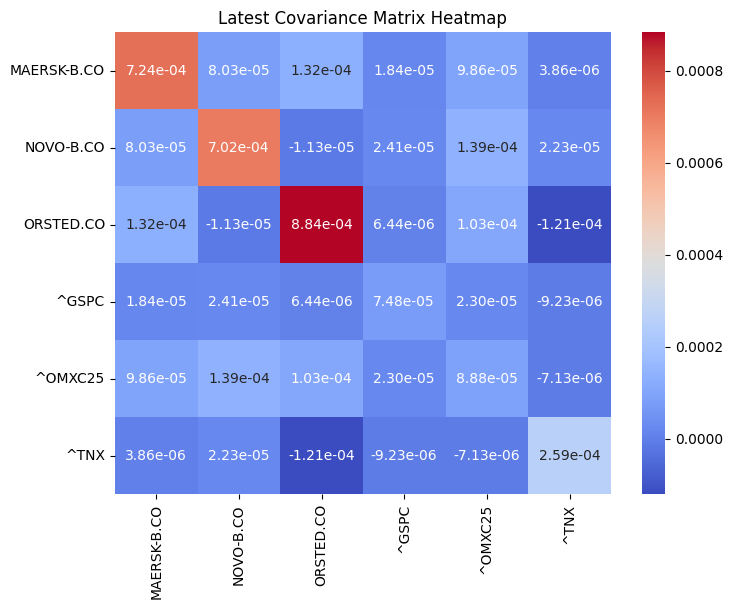

In [27]:

# Select the latest covariance matrix
latest_cov = cov_matrices[-1]

# Create a heatmap of the covariance matrix
plt.figure(figsize=(8, 6))
sns.heatmap(latest_cov, annot=True, fmt=".2e", cmap="coolwarm",
            xticklabels=close_prices.columns, yticklabels=close_prices.columns)
plt.title("Latest Covariance Matrix Heatmap")


In [28]:
# Prepare DataFrames for export

# Returns (log returns)
returns_df = normalized_prices_adj_log_ret.copy()

# Volatility: square root of the diagonal from the latest covariance matrix
volatility = np.sqrt(np.diag(cov_matrices[-1]))
volatility_df = pd.DataFrame(volatility, index=close_prices.columns, columns=["Volatility"])

# Latest Covariance matrix
cov_df = pd.DataFrame(cov_matrices[-1], index=close_prices.columns, columns=close_prices.columns)

# Latest Correlation matrix
corr_df = pd.DataFrame(corr_matrices[-1], index=close_prices.columns, columns=close_prices.columns)

# Export all DataFrames to an Excel file with separate sheets
excel_filename = "portfolio_metrics.xlsx"
with pd.ExcelWriter(excel_filename) as writer:
    returns_df.to_excel(writer, sheet_name="Returns")
    volatility_df.to_excel(writer, sheet_name="Volatility")
    cov_df.to_excel(writer, sheet_name="Covariance")
    corr_df.to_excel(writer, sheet_name="Correlation")

print(f"Exported portfolio metrics to '{excel_filename}'")

Exported portfolio metrics to 'portfolio_metrics.xlsx'


## Thor added part


In [29]:
# Forecasting Future Asset Returns using Monte Carlo Simulation (GBM)
# Based on the methodology in Notebook 2

# 1. Estimate Drift and Volatility from Historical (Daily) Log Returns
mu_daily = normalized_prices_adj_log_ret.mean()
sigma_daily = normalized_prices_adj_log_ret.std()

# Convert daily estimates to weekly estimates (assuming 5 trading days per week)
mu_weekly = mu_daily * 5
sigma_weekly = sigma_daily * np.sqrt(5)

print("Weekly drift estimates:")
print(mu_weekly)
print("\nWeekly volatility estimates:")
print(sigma_weekly)

Weekly drift estimates:
Ticker
MAERSK-B.CO    0.001646
NOVO-B.CO      0.004174
ORSTED.CO      0.000863
^GSPC          0.002535
^OMXC25        0.001482
^TNX           0.001440
dtype: float64

Weekly volatility estimates:
Ticker
MAERSK-B.CO    0.055249
NOVO-B.CO      0.040302
ORSTED.CO      0.052670
^GSPC          0.026564
^OMXC25        0.024248
^TNX           0.073214
dtype: float64


In [30]:
# %%
# 2. Monte Carlo Simulation of Future Price Paths for Each Asset

# Simulation parameters
num_years = 45
num_weeks = 52 * num_years
num_paths = 10000
dt = 1 / 52  # weekly time step

# Dictionary to store simulation results for each asset
simulated_prices_dict = {}

# Loop over each asset in the portfolio
for asset in normalized_prices.columns:
    S0 = normalized_prices[asset].iloc[-1]
    mu = mu_weekly[asset]
    sigma = sigma_weekly[asset]
    
    # Initialize simulation array: rows for time steps, columns for simulation paths
    simulated_prices = np.zeros((num_weeks + 1, num_paths))
    simulated_prices[0] = S0  # initial price
    
    # Run the simulation
    for t in range(1, num_weeks + 1):
        epsilon = np.random.normal(0, 1, num_paths)
        simulated_prices[t] = simulated_prices[t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * epsilon)
    
    simulated_prices_dict[asset] = simulated_prices

print("Monte Carlo simulation completed for all assets.")

Monte Carlo simulation completed for all assets.


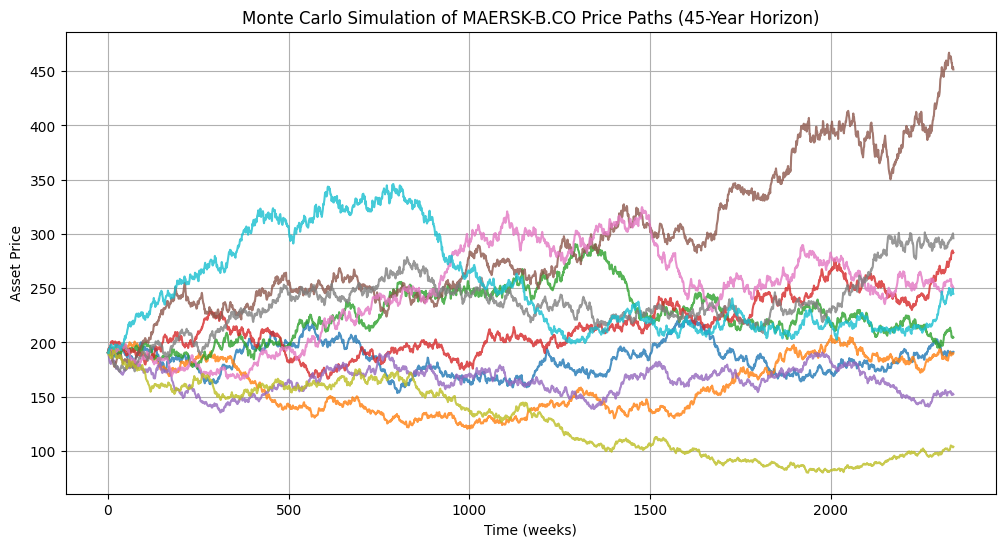

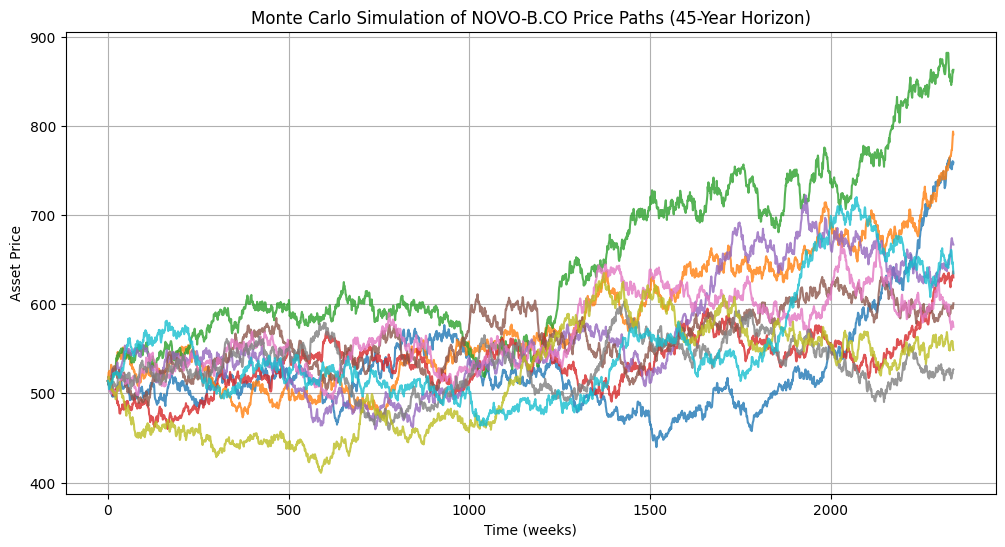

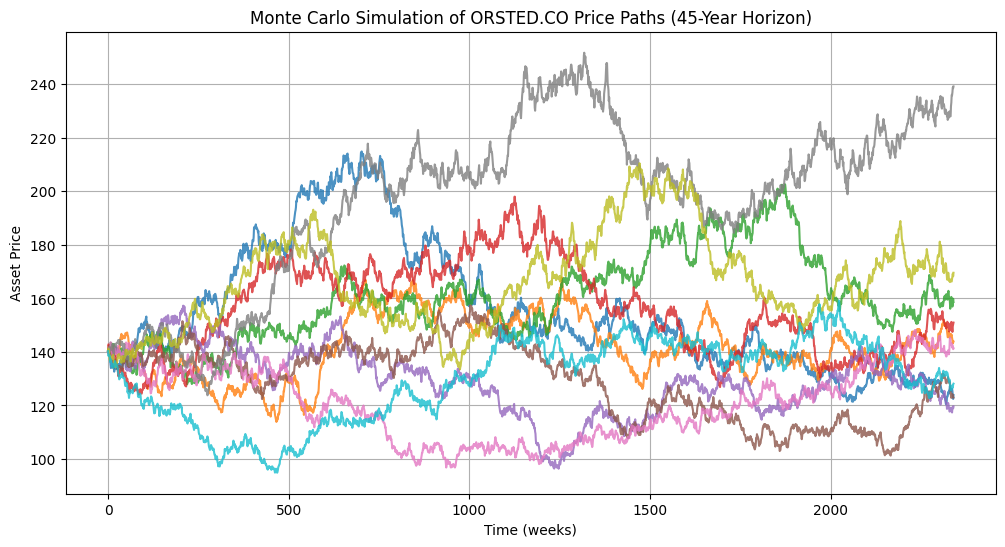

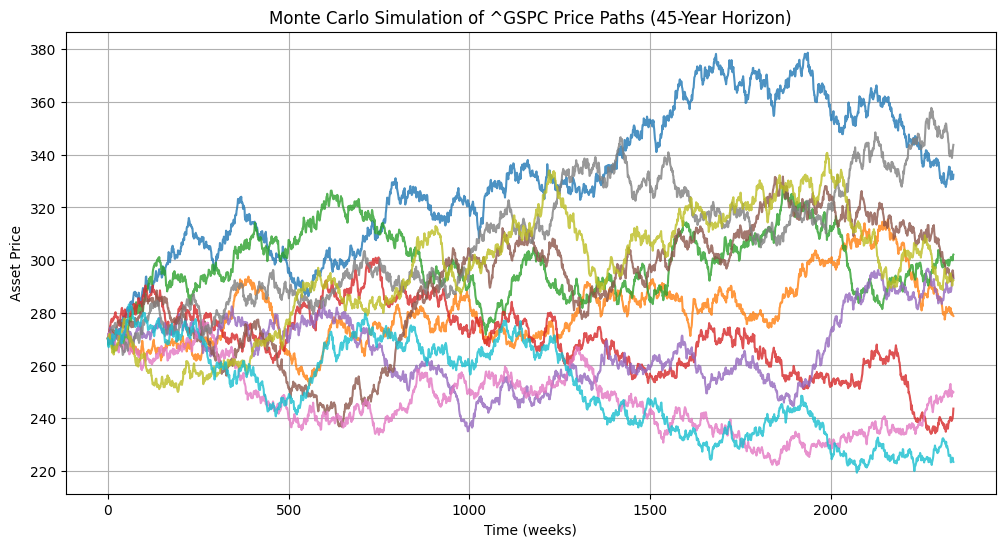

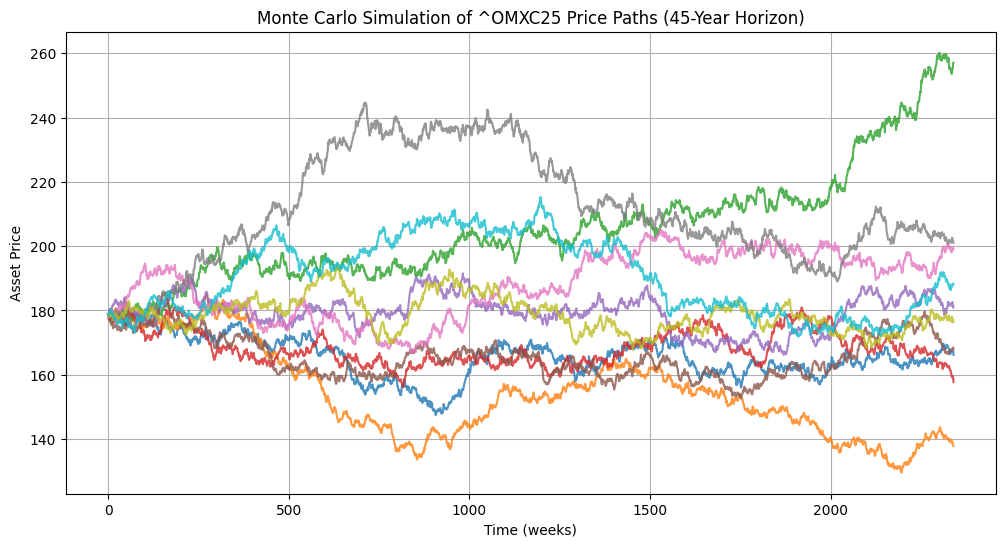

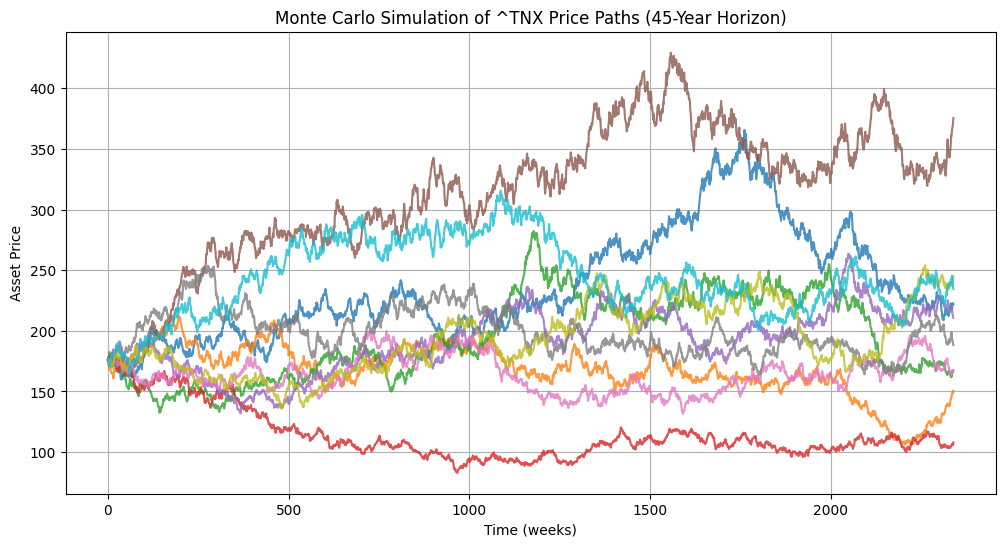

In [ ]:
# 3. Plot Sample Simulated Price Paths for Each Asset

for asset, sim_prices in simulated_prices_dict.items():
    plt.figure(figsize=(12, 6))
    for i in range(10):  # Plot 10 sample paths for illustration
        plt.plot(sim_prices[:, i], lw=1.5, alpha=0.8)
    plt.xlabel('Time (weeks)')
    plt.ylabel('Asset Price')
    plt.title(f'Monte Carlo Simulation of {asset} Price Paths (45-Year Horizon)')
    plt.grid(True)
    plt.show()

In [32]:
# 4. Summarize the Forecasted Returns at the End of the Simulation Horizon

forecast_summary = {}

for asset, sim_prices in simulated_prices_dict.items():
    S0 = normalized_prices[asset].iloc[-1]
    # Compute forecasted log returns at the end of the simulation horizon
    forecast_return = np.log(sim_prices[-1] / S0)
    summary = {
        'Mean Return': np.mean(forecast_return),
        'Std Dev': np.std(forecast_return),
        '5th Percentile': np.percentile(forecast_return, 5),
        '95th Percentile': np.percentile(forecast_return, 95)
    }
    forecast_summary[asset] = summary

forecast_summary_df = pd.DataFrame(forecast_summary).T
print("Forecasted returns summary at the end of 45 years:")
print(forecast_summary_df)

Forecasted returns summary at the end of 45 years:
             Mean Return   Std Dev  5th Percentile  95th Percentile
MAERSK-B.CO    -0.001576  0.372938       -0.622389         0.610585
NOVO-B.CO       0.150328  0.269670       -0.299222         0.590733
ORSTED.CO      -0.024446  0.355355       -0.604020         0.550760
^GSPC           0.096652  0.176793       -0.190247         0.390033
^OMXC25         0.053394  0.161437       -0.206945         0.318549
^TNX           -0.049596  0.493047       -0.869444         0.758666


# Simulation of equity asset prices
The equity prices are simulated using Geometric Brownian Motion

In [3]:
import yfinance as yf
from Simulation.Models.geometric_brownian_motion_model import GBMSimulator

## S&P500

[*********************100%***********************]  1 of 1 completed


Estimated weekly drift: 0.0095, Annual drift: 0.4940
Estimated weekly volatility: 0.0420, Annual volatility: 0.3031


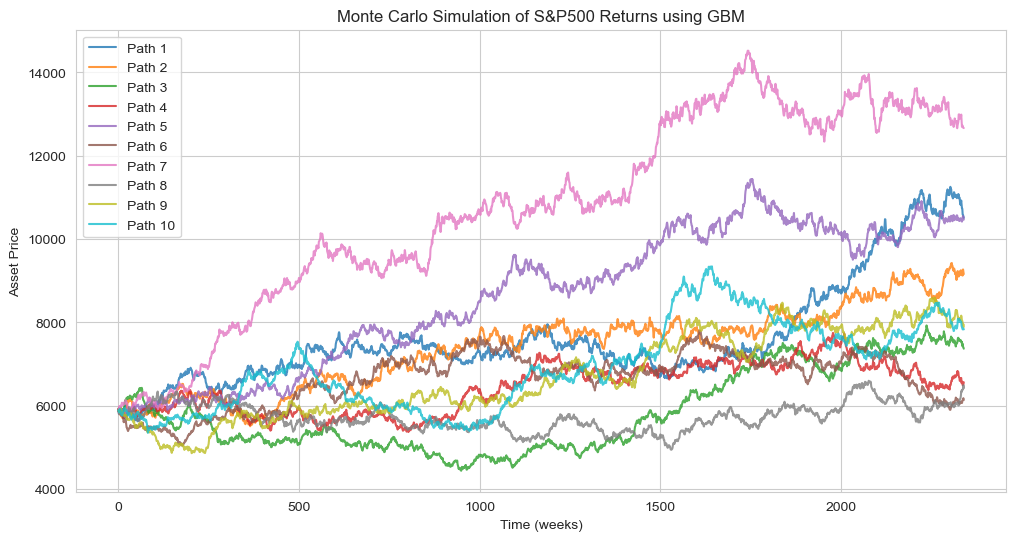

In [4]:
ticker = "^GSPC"
start_date = "2010-01-01"
end_date = "2025-01-01"
freq = "1mo"
data_sp500 = yf.download(ticker, start=start_date, end=end_date, interval=freq)
prices_sp500 = data_sp500["Adj Close"]

#Create an instance of the simulator
sp500_simulator = GBMSimulator(prices_sp500)

#Run simulation
simulated_sp500_prices = sp500_simulator.simulate_gbm(num_years=45, num_paths=10000)

#Plot simulation
sp500_simulator.plot_simulation(simulated_sp500_prices, num_paths_to_plot=10,
                                title="Monte Carlo Simulation of S&P500 Returns using GBM")

